In [1]:
import qiskit
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from signal_torch.dataset.pu import PU
from signal_torch.transforms import transforms

In [2]:
transforms_compose = transforms.Compose([
                        #transforms.AddGaussian(),
                        transforms.ExtractFeatures(list_features=["mean","var","skew","max_min","kurtosis","root_mean_square"]),
                        transforms.ToNumpy()])

In [3]:
PU_dataset = PU("PU", new_length= 8192, overlap= 0.01, transform= transforms_compose, download=False)

Error Loading:  PU\KA08\N15_M01_F10_KA08_2.mat


In [4]:
pu_data, pu_target = PU_dataset._get_numpy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(pu_data, pu_target, test_size=0.33, random_state=42)

In [6]:
import pandas as pd
import numpy as np

           Mean  Variance  Skewness  max - min   Kurtosis      RMSE  Label
0     -0.017824  0.180138  0.425100   6.600952  14.685596  0.424401    2.0
1      0.043653  0.010234 -0.056837   1.425171   8.026580  0.101157    2.0
2     -0.019614  0.037429 -0.001997   2.062988   4.211169  0.193454    0.0
3     -0.011947  0.058569  0.062986   3.198242   7.132256  0.241996    1.0
4     -0.020614  0.140245 -0.242444   7.086182  18.449263  0.374470    0.0
...         ...       ...       ...        ...        ...       ...    ...
14759 -0.016253  0.009941  0.065604   1.962280  18.321024  0.099701    0.0
14760 -0.017330  0.267135  0.824632   6.860352  14.376016  0.516819    1.0
14761 -0.012406  0.028803 -0.706196   4.324341  43.252129  0.169705    0.0
14762 -0.012540  0.061632 -0.340749   4.806519  15.710632  0.248243    0.0
14763 -0.010881  0.027159  0.149088   3.271484  18.768621  0.164789    1.0

[14764 rows x 7 columns]


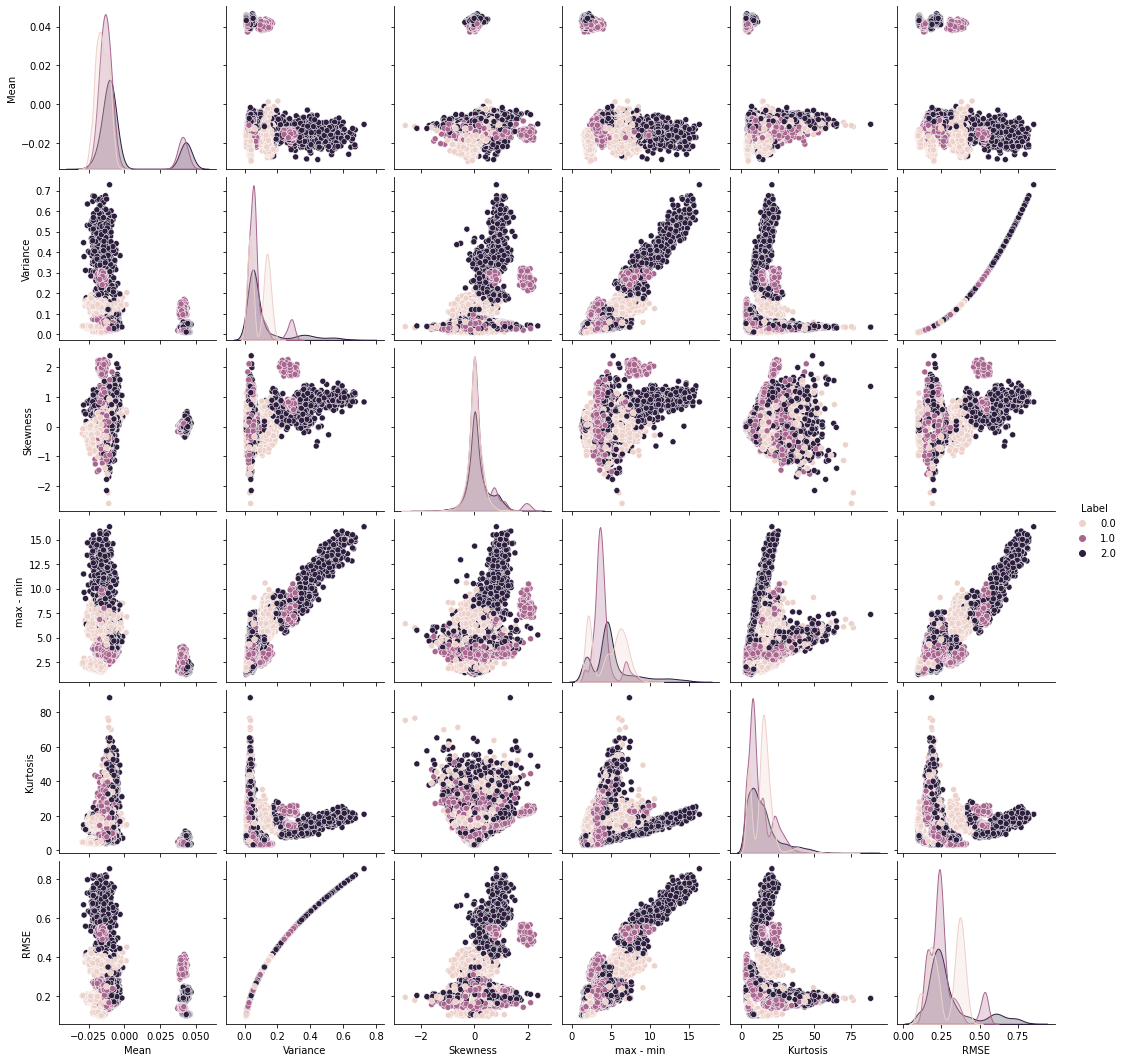

In [9]:
data_df = pd.DataFrame(np.hstack( ( X_test ,y_test.reshape(-1,1)) ), columns = ["Mean","Variance","Skewness","max - min","Kurtosis","RMSE","Label"])
sns.pairplot(data_df, hue = "Label")

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

In [11]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)
num_inputs = 6

In [12]:
# Define feature map and ansatz
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw()

┌──────────────────────────────────────────────┐»
q_0: ┤0                                             ├»
     │                                              │»
q_1: ┤1                                             ├»
     │                                              │»
q_2: ┤2                                             ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5]) │»
q_3: ┤3                                             ├»
     │                                              │»
q_4: ┤4                                             ├»
     │                                              │»
q_5: ┤5                                             ├»
     └──────────────────────────────────────────────┘»
«     ┌────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                               ├
«     │                                                                                │
«q_1: ┤1                                                                               ├
«     │                                                                                │
«q_2: ┤2                                                                               ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) │
«q_3: ┤3                                                                               ├
«     │                                                                                │
«q_4: ┤4                                                                               ├
«     │                                                                                │
«q_5: ┤5                                                                               ├
«     └────────────────────────────────────────────────────────────────────────────────┘

In [15]:
output_shape = 3  

In [26]:
# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


In [27]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [28]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
)

In [29]:
objective_func_vals = []
circuit_classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = circuit_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('PU Classification 0:Baseline, 1:IR, 2:OR');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');

array([1., 2., 1., ..., 2., 0., 1.], dtype=float32)